In [97]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from numba import jit, njit, prange
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

In [2]:
xlen = 3 #mm
ylen = 0.75 #mm
step = 5*10**(-3)
needle_spacing  = 2.8 # mm
Xaxis = np.arange(-xlen,xlen+step,step)
Yaxis = np.arange(-ylen,ylen+step,step)
X,Y = np.meshgrid(Xaxis,Yaxis)
diameter = 0.5 #mm

In [3]:
def R_cones(z,needle_spacing,diameter):
    z_0 = needle_spacing * 0.5
    if np.abs(z) < z_0 :
        return 0
    if np.abs(z) >= z_0 : 
        return 0.5 * diameter/(xlen - z_0) * (np.abs(z) - z_0)

def R_parabolic(z,needle_spacing,diameter):
    '''
    diameter: the diameter of the needle at the end of the z_value'''
    z_0 = needle_spacing * 0.5
    if np.abs(z) < z_0 :
        return 0
    if np.abs(z) >= z_0 :
        return 0.5 * diameter/((xlen - z_0)**0.5) * (np.abs(z)-z_0)**0.5 

In [4]:
def draw_cones(X,Y,needle_spacing,diameter):
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_cones(X[i,j],needle_spacing,diameter))) :
                cones[i,j] = 1
    return cones      


def draw_parabolic(X,Y,needle_spacing,diameter):
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter))) :
                cones[i,j] = 1
    return cones

def draw_parabolic_single(X,Y,needle_spacing,diameter):
    
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if (X[i,j] > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter))) :
                cones[i,j] = 1
    return cones

def draw_parabolic_asym(X,Y,needle_spacing,diameter,asym_factor):
    cones = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] > 0:
                if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter))) :
                    cones[i,j] = 1
            if X[i,j] < 0:
                if (np.abs(X[i,j]) > (needle_spacing*0.5)) & (np.abs(Y[i,j]) <= np.abs(R_parabolic(X[i,j],needle_spacing,diameter+asym_factor))) :
                    cones[i,j] = 1
    return cones

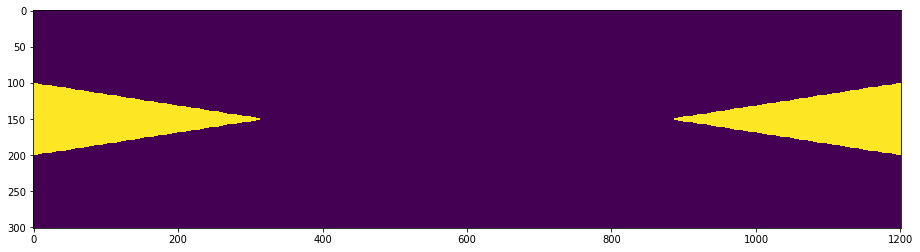

In [5]:
needle_cone_1 = draw_cones(X,Y,needle_spacing,diameter)
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.imshow(needle_cone_1)
plt.show()

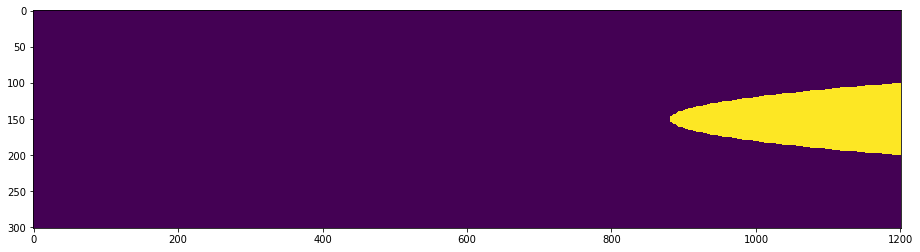

Wall time: 2.2 s


In [6]:
%%time
needle_parabolic_asym = draw_parabolic_single(X,Y,needle_spacing,diameter)
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.imshow(needle_parabolic_asym)
plt.show()

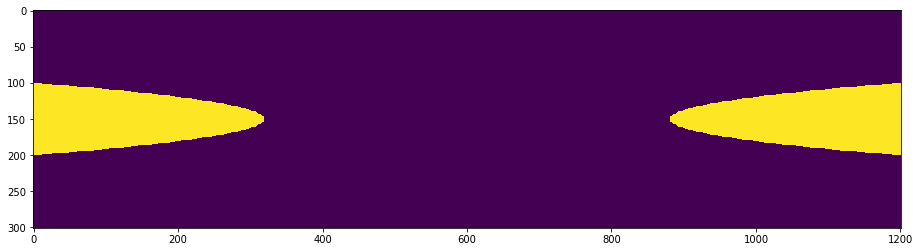

Wall time: 2.66 s


In [7]:
%%time
needle_parabolic_1 = draw_parabolic(X,Y,needle_spacing,diameter)
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.imshow(needle_parabolic_1)
plt.show()

In [8]:
def set_grid_points(blades):
    grid_points = []
    for i in range(0,blades.shape[0]-1):
        for j in range(0,blades.shape[1]-1):
            if blades[i,j] == 0 :
                grid_points.append((i,j))
    return grid_points


@jit(nopython=True)
def fast_numb_solve_test(blades,gp,iterations,tol):
    #largest_update = 0
    for iteration in range(0,iterations):
        largest_update = 0
        for grid_point in gp:
            i = grid_point[0]
            j = grid_point[1]
            value = 0.25 * (blades[i+1,j] + blades[i-1,j] + blades[i,j+1] + blades[i,j-1])
            update = np.abs(value - blades[i,j])
            blades[i,j] = value 
            if update > largest_update : 
                largest_update = update
        if largest_update < tol:
            break
    print(iteration)
    print(largest_update)
    return blades



q = 1.60217662*(10**(-19))
m = 2.8395214559472*10**(-25)



def fit_quadratic(z,V_0,K):
    return V_0 + 0.5 * K * z**2

def trapfreq(k):
    return np.sqrt(np.abs(k)/m)/(2*np.pi)



def solve_parabolic(X,Y,needle_spacing,diameter):
    needle_parabolic = draw_parabolic(X,Y,needle_spacing,diameter)
    grid_points_parabolic = set_grid_points(needle_parabolic)
    parabolic_solved = fast_numb_solve_test(needle_parabolic,grid_points_parabolic,100000,1e-6)
    a = 980
    b = 1021
    z_data = X[150,a:b] * 10**(-3)
    V_data = parabolic_solved[150,a:b] * q
    popt, pconv = curve_fit(fit_quadratic,z_data,V_data)
    return trapfreq(popt[1])


def solve_cone(X,Y,needle_spacing,diameter):
    needle_cone = draw_cones(X,Y,needle_spacing,diameter)
    grid_points_cones = set_grid_points(needle_cone)
    cone_solved = fast_numb_solve_test(needle_cone,grid_points_cones,100000,1e-6)
    a = 980
    b = 1021
    z_data = X[150,a:b] * 10**(-3)
    V_data = cone_solved[150,a:b] * q
    popt, pconv = curve_fit(fit_quadratic,z_data,V_data)
    return trapfreq(popt[1])

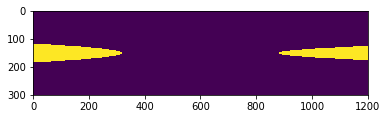

In [9]:
diameter1 = 0.251 #for needle 8 from data
diameter2 = 0.336 # for needle 7 from data
image_for_grid_points = draw_parabolic_single(X,Y,needle_spacing,diameter1) \
                        + np.flip(draw_parabolic_single(X,Y,needle_spacing,diameter2))
plt.imshow(image_for_grid_points)

In [10]:
grid_points = np.array(set_grid_points(image_for_grid_points))

In [11]:
needle_1 = draw_parabolic_single(X,Y,needle_spacing,diameter1)

In [12]:
%%time
needle_1_solved = fast_numb_solve_test(needle_1,grid_points,100000,1e-6)

35978
9.9995486754767e-07
Wall time: 56.4 s


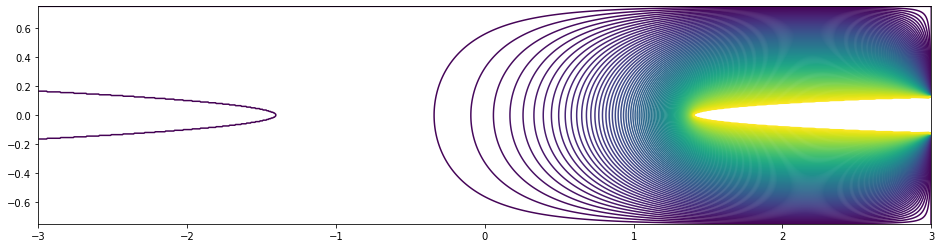

In [13]:
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.contour(X,Y,needle_1_solved,100)
plt.show()

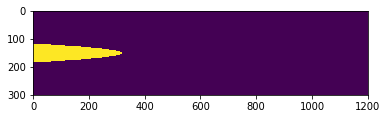

In [14]:
needle_2 = np.flip(draw_parabolic_single(X,Y,needle_spacing,diameter2))
plt.imshow(needle_2)

In [15]:
%%time
needle_2_solved = fast_numb_solve_test(needle_2,grid_points,100000,1e-6)

35776
9.999889498679693e-07
Wall time: 59 s


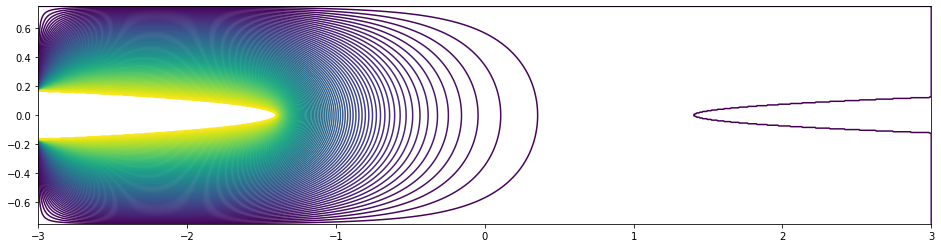

In [16]:
fig = plt.figure(figsize = (16,4))
ax1 = fig.add_subplot(111)
ax1.contour(X,Y,needle_2_solved,100)
plt.show()

In [54]:
plt.rcParams.update({'font.size': 16})

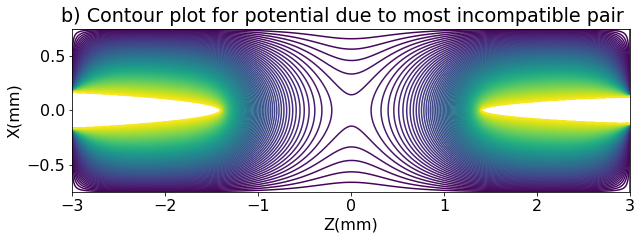

In [108]:
fig = plt.figure(figsize = (10,3))
fig.suptitle('b) Contour plot for potential due to most incompatible pair')
ax1 = fig.add_subplot(111)
ax1.contour(X,Y,needle_1_solved+needle_2_solved,100)
ax1.set_xlabel('Z(mm)')
ax1.set_ylabel('X(mm)')
plt.savefig('asym_potential_solved.svg')
plt.show()

In [24]:
asym_pair = needle_1_solved+needle_2_solved

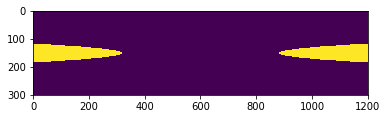

In [18]:
diameter = .336
parabolic_pair = draw_parabolic(X,Y,needle_spacing,diameter)
plt.imshow(parabolic_pair)

In [19]:
parabolic_pair_grid_points = np.array(set_grid_points(parabolic_pair))

In [20]:
%%time
parabolic_pair_solved = fast_numb_solve_test(parabolic_pair,parabolic_pair_grid_points,100000,1e-6)

40883
9.99986653232865e-07
Wall time: 1min


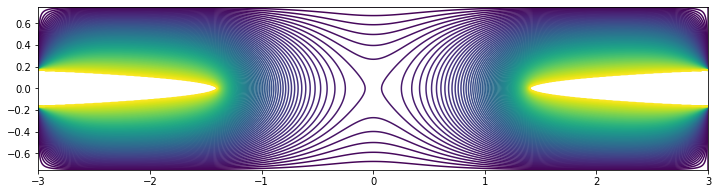

In [42]:
fig = plt.figure(figsize = (12,3))
ax1 = fig.add_subplot(111)
ax1.contour(X,Y,parabolic_pair_solved,100)
plt.show()

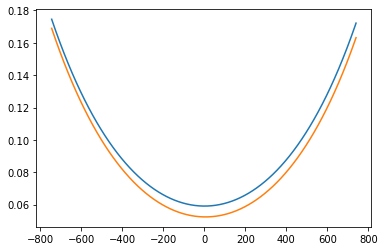

In [35]:
extent = 0.75
y_zero_ind = int(ylen//step + 1)
x_zero_ind = int(xlen//step + 1)
a = int(x_zero_ind-extent//step)
b = int(x_zero_ind+extent//step)
plt.plot(X[y_zero_ind,a:b]*1000,parabolic_pair[y_zero_ind,a:b],X[y_zero_ind,a:b]*1000,asym_pair[y_zero_ind,a:b])
plt.show()

In [36]:
def fit_asym(xpoint,needle1_voltage,needle2_voltage):
    extent = 0.75
    y_zero_ind = int(ylen//step + 1)
    x_zero_ind = int(xlen//step + 1)
    a = int(x_zero_ind-extent//step)
    b = int(x_zero_ind+extent//step)
    y_data = needle1_voltage*needle_1_solved[y_zero_ind,a:b] + needle2_voltage*needle_2_solved[y_zero_ind,a:b]
    x_data = X[y_zero_ind,a:b]
    return np.interp(xpoint,x_data,y_data)

In [37]:
popt, pconv = curve_fit(fit_asym,X[y_zero_ind,a:b],parabolic_pair[y_zero_ind,a:b])

In [29]:
popt

array([1.06538235, 1.04240651])

In [76]:
pconv

array([[ 4.94918671e-06, -1.82460348e-06],
       [-1.82460348e-06,  4.29355690e-06]])

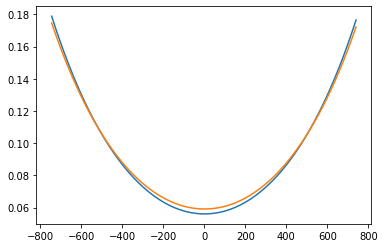

In [40]:
plt.plot(X[y_zero_ind,a:b]*1000,fit_asym(X[y_zero_ind,a:b],popt[0], popt[1]),X[y_zero_ind,a:b]*1000,parabolic_pair[y_zero_ind,a:b])

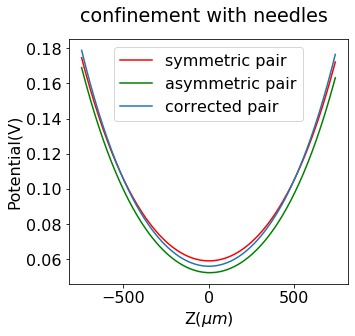

In [106]:
extent = 0.75
y_zero_ind = int(ylen//step + 1)
x_zero_ind = int(xlen//step + 1)
a = int(x_zero_ind-extent//step)
b = int(x_zero_ind+extent//step)
fig = plt.figure(figsize=(5,4.5))
fig.suptitle('confinement with needles')
ax = fig.add_subplot(111)
ax.plot(X[y_zero_ind,a:b]*1000,parabolic_pair[y_zero_ind,a:b],'r',label = 'symmetric pair')
ax.plot(X[y_zero_ind,a:b]*1000,asym_pair[y_zero_ind,a:b],'g',label='asymmetric pair')
ax.plot(X[y_zero_ind,a:b]*1000,fit_asym(X[y_zero_ind,a:b],popt[0], popt[1]),label = 'corrected pair')
ax.set_xlabel('Z($\mu m$)')
ax.set_ylabel('Potential(V)')
ax.legend()
#plt.savefig('potential_correction.svg')
plt.show()

In [56]:
q = 1.60217662*(10**(-19))
m = 2.8395214559472*10**(-25)
def fit_quadratic(z,V_0,K):
    return V_0 + 0.5 * K * z**2

def trapfreq(k):
    return np.sqrt(np.abs(k)/m)/(2*np.pi)

In [ ]:
q = 1.60217662*(10**(-19))
m = 2.8395214559472*10**(-25)

In [68]:
a = 980
b = 1021
z_data = X[150,a:b] * 10**(-3)
V_data_cone = cone_solved[150,a:b] * q
V_data_par_1 = parabolic_solved[150,a:b] * q

In [69]:
popt, pconv = curve_fit(fit_quadratic,z_data,V_data_cone)

In [70]:
trapfreq(popt[1])

67164.56001562368

In [74]:
%%time
solve_parabolic(X,Y,needle_spacing,diameter)

40889
9.999823568224153e-07
Wall time: 1min 38s


69669.05732497452

In [89]:
solve_cone(X,Y,needle_spacing-1,diameter)

44017
9.999490225565122e-07


113784.20720722675

In [91]:
spacings  = np.arange(1,3.1,0.1)

In [92]:
%%time
cone_frequencies = []
parabolic_frequencies = []
for spacing in spacings:
    cone_freq = solve_cone(X,Y,spacing,diameter)
    para_freq = solve_parabolic(X,Y,spacing,diameter)
    cone_frequencies.append(cone_freq)
    parabolic_frequencies.append(para_freq)

37879
9.999610120492441e-07
36812
9.999631172541434e-07
39346
9.999142107641745e-07
38434
9.999213027023224e-07
40582
9.999479935185462e-07
39815
9.999644788316608e-07
41600
9.999243215097486e-07
40965
9.9994206759213e-07
42416
9.999672548888228e-07
41898
9.999261703086404e-07
43048
9.999750617550873e-07
42636
9.999578958197475e-07
43515
9.99917418170737e-07
43198
9.999649794312226e-07
43832
9.999951707806432e-07
43597
9.999626241763426e-07
44017
9.999490225565122e-07
43860
9.999495995116625e-07
44082
9.99940423518364e-07
43996
9.99982999738691e-07
44039
9.999268366644998e-07
44019
9.999862075060761e-07
43897
9.99941456081288e-07
43940
9.99955060282387e-07
43663
9.999564660745364e-07
43767
9.999930670467894e-07
43341
9.99991698669156e-07
43506
9.999340805227908e-07
42934
9.999367148183502e-07
43160
9.999659035253572e-07
42439
9.99952738833798e-07
42728
9.99982599156346e-07
41853
9.999416135386685e-07
42211
9.999669754873208e-07
41166
9.999975925031879e-07
41600
9.999711357705499e-07
40

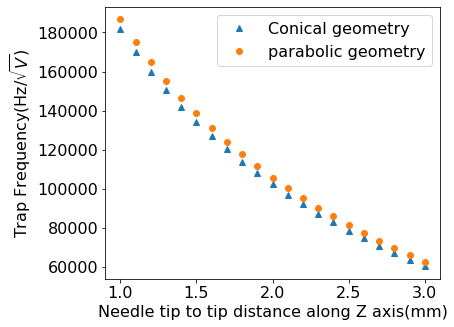

In [92]:
fig = plt.figure(figsize = (6,5))
ax1 = fig.add_subplot(111)
ax1.plot(spacings,cone_frequencies,'^',label = 'Conical geometry')
ax1.plot(spacings,parabolic_frequencies,'o',label = 'parabolic geometry')
ax1.set_ylabel('Trap Frequency(Hz/$\sqrt{V}$)')
ax1.set_xlabel('Needle tip to tip distance along Z axis(mm)')
plt.legend()
plt.savefig('geometry_comparison.svg')
plt.show()

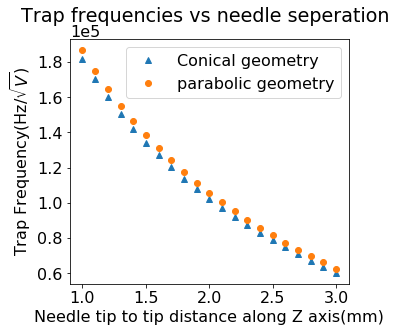

In [105]:
fig = plt.figure(figsize = (5,4.5))
ax1 = fig.add_subplot(111)
fig.suptitle('Trap frequencies vs needle seperation')
ax1.plot(spacings,cone_frequencies,'^',label = 'Conical geometry')
ax1.plot(spacings,parabolic_frequencies,'o',label = 'parabolic geometry')
ax1.set_ylabel('Trap Frequency(Hz/$\sqrt{V}$)')
ax1.set_xlabel('Needle tip to tip distance along Z axis(mm)')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
#plt.savefig('geometry_comparison.svg')
plt.show()

In [98]:
np.save('cone_frequencies.npy',cone_frequencies)
np.save('parabolic_frequencies.npy',parabolic_frequencies)

In [103]:
np.save('spacings.npy',spacings)

In [84]:
cone_frequencies = np.load('cone_frequencies.npy')
parabolic_frequencies = np.load('parabolic_frequencies.npy')
spacings = np.load('spacings.npy')

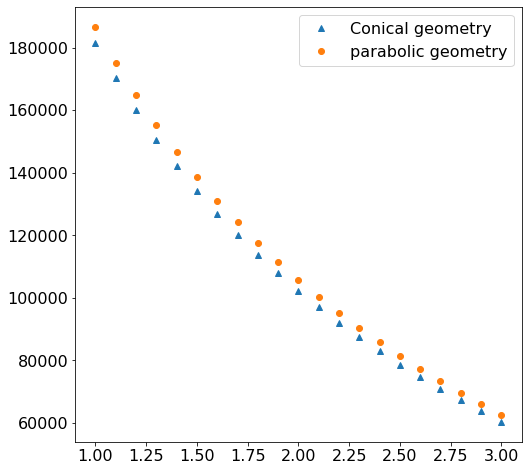

In [85]:
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.plot(spacings,cone_frequencies,'^',label = 'Conical geometry')
ax1.plot(spacings,parabolic_frequencies,'o',label = 'parabolic geometry')
plt.legend()
plt.show()